训练自编码器

用现在筛选过的数据训练自编码器


纯卷积

---
有约束

效果：7.135801792144775

无约束

效果：0.004993373062461615

In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter


from model.PIAE_models import T7DAE3,Vehicle_Model_Methods

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


显卡参与训练


In [2]:


# 1. 加载预处理后的数据
def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/data/Task2_data'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_noisy_data.kpl'))
dataset = TensorDataset(tarin_data[1],tarin_data[0])
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)


val_data = load_preprocessed_data(os.path.join(input_file,'val_noisy_data.kpl'))
val_input = val_data[1].to(device)
val_label = val_data[0].to(device)

In [3]:


class CustomLoss(nn.Module,Vehicle_Model_Methods):
    def __init__(self):
        super(CustomLoss, self).__init__()


    def forward(self, outputs, targets):

        # 计算自定义损失
        # 首先均方误差作为基础，保证平滑结果和原来数据的相似性
        mse_loss = nn.MSELoss()(outputs, targets)

        ax_limit_loss,delta_limit_loss=self.constrain_loss(outputs)

        custom_loss = mse_loss + ax_limit_loss*1e-1  + delta_limit_loss*1e1
        # custom_loss =  ax_limit_loss*1e-1  + delta_limit_loss*1e1
        # custom_loss =  mse_loss + loss_x*5e-2  + loss_y*5e-1 + ax_limit_loss*1e-1  + delta_limit_loss*1e1
        return custom_loss

In [4]:
# 3. 定义模型、损失函数和优化器
model = T7DAE3()
criterion = nn.MSELoss()
criterion2 = CustomLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

T7DAE3(
  (encoder): Sequential(
    (0): Conv1d(2, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Conv1d(30, 20, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(20, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(10, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)

In [36]:
# 4. 训练模型Autoencoder


# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/logs/log8-1')
# log8 为有模型惩罚约束
# log8-1 无模型惩罚约束

epochs = 600
best_loss = float('inf')

for epoch in range(epochs):
    for batch_idx, (inputs,label) in enumerate(dataloader):  
        # 添加噪声
        inputs = inputs.to(device)  # 将输入数据移动到同一设备
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # print('output shape:',outputs.shape)

        # loss = criterion2(outputs, label) # 没有-1
        loss = criterion(outputs, label) # 有-1

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}')

    with torch.no_grad():
        
        val_out = model(val_input)
        loss_val = criterion(val_out, val_label)
        orig_err = criterion(val_input, val_label)
    
    print(f'验证集上的指标为:{loss_val}，总噪声为:{orig_err},减少噪声{orig_err-loss_val}')
    
    if loss_val.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task8-1_model_best.pth')
        best_loss = loss_val.item()

    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', loss_val, epoch)

# 关闭SummaryWriter
writer.close()




Epoch 1, Train Loss: 0.006052227225154638
验证集上的指标为:0.007786999456584454，总噪声为:0.025070490315556526,减少噪声0.017283491790294647
Epoch 2, Train Loss: 0.008129026740789413
验证集上的指标为:0.007372224237769842，总噪声为:0.025070490315556526,减少噪声0.017698265612125397
Epoch 3, Train Loss: 0.005500149447470903
验证集上的指标为:0.006517629139125347，总噪声为:0.025070490315556526,减少噪声0.018552862107753754
Epoch 4, Train Loss: 0.007147258147597313
验证集上的指标为:0.00762283755466342，总噪声为:0.025070490315556526,减少噪声0.01744765229523182
Epoch 5, Train Loss: 0.006191739346832037
验证集上的指标为:0.006422535981982946，总噪声为:0.025070490315556526,减少噪声0.018647953867912292
Epoch 6, Train Loss: 0.007230574265122414
验证集上的指标为:0.006363098509609699，总噪声为:0.025070490315556526,减少噪声0.018707390874624252
Epoch 7, Train Loss: 0.006811021361500025
验证集上的指标为:0.00651369197294116，总噪声为:0.025070490315556526,减少噪声0.01855679787695408
Epoch 8, Train Loss: 0.005624797660857439
验证集上的指标为:0.00574909383431077，总噪声为:0.025070490315556526,减少噪声0.019321396946907043
Epoch 9, Train Loss: 

验证集上的指标为:0.004993373062461615，总噪声为:0.025070490315556526,减少噪声0.020077116787433624


<Figure size 1000x700 with 0 Axes>

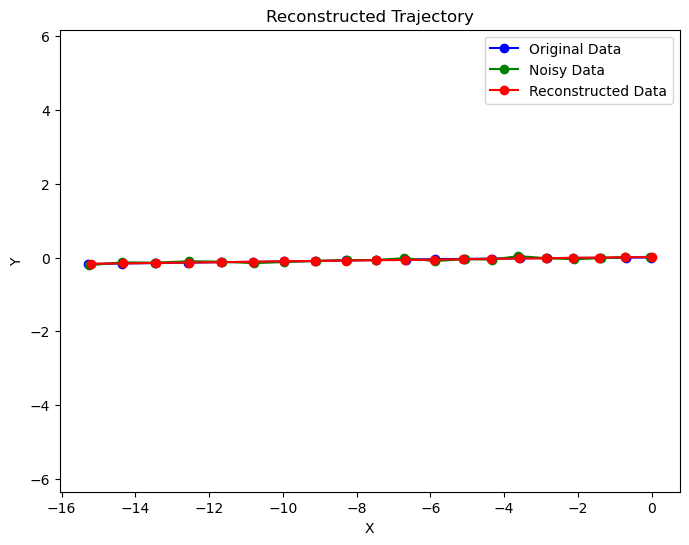

In [5]:
# model = T7DAE1()
# model.to(device)

model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task8-1_model_best.pth',weights_only=True))

import numpy as np

model.eval()

with torch.no_grad():
    val_input = val_input.to(device)
    val_out = model(val_input)
    loss_val = criterion(val_out, val_label)
    orig_err = criterion(val_input, val_label)
print(f'验证集上的指标为:{loss_val}，总噪声为:{orig_err},减少噪声{orig_err-loss_val}')

# 6. 绘制原始轨迹和重建后的轨迹
plt.figure(figsize=(10, 7))

# 绘制原始轨迹
# num = 845
num = np.random.randint(0,30000)
plt.figure(figsize=[8,6])
plt.plot(val_label.cpu().numpy()[num,:,0], val_label.cpu().numpy()[num,:,1], '-o',c='blue', label='Original Data')
plt.plot(val_input.cpu().numpy()[num,:,0], val_input.cpu().numpy()[num,:,1], '-o', c='green', label='Noisy Data')
plt.plot(val_out.cpu().numpy()[num,:,0], val_out.cpu().numpy()[num,:,1], '-o', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()

In [7]:
# 定义临时类
# 创建一个临时类并继承 MyMixin
class TempClass(Vehicle_Model_Methods):
    pass

# 实例化临时类
temp_instance = TempClass()
ax_out_rate,delta_out_rate,traj_out_rate=temp_instance.constrain_count(val_input,10,0.25)
print('加速度突破率：',ax_out_rate)
print('转向突破率：',delta_out_rate)
print('轨迹突破率：',traj_out_rate)

加速度突破率： 0.714092493057251
转向突破率： 0.6231790781021118
轨迹突破率： 0.9953458905220032
